In [1]:
import pylab as plt
import numpy as np
import time as tm 
from sys import argv
from scipy.stats import kurtosis

In [2]:
#Harmonic force and internal energy
def energy_force(x, t, *args):
    v0 = args[0]
    ks = args[1]
    F = -ks*(x - v0*t)
    U = (ks/2)*abs(x-v0*t)**2
    return F, U

In [3]:
def position_update(x, v, dt):
    x_new = x + v*dt/2.
    return x_new

def velocity_update(v, F, dt):
    v_new = v + F*dt/2.
    return v_new

def random_velocity_update(v, dt, *args):
    mu, lamb = args[0], args[1]
    gamma, kBT = args[2], args[3]
    Rg = np.random.normal(0,1)
    Rp = np.random.poisson(lamb, size=None)
    
    c1 = np.exp(-gamma*dt)
    g2 = np.sqrt(1-np.exp(-2*gamma*dt))*np.sqrt(kBT)
    p2 = np.sqrt(1-np.exp(-2*gamma*dt))*np.sqrt(mu*lamb)
    
    v_new = c1*v + g2*Rg + p2*Rp
    return v_new

def BAOAB_method(*args):
    mu, lamb = args[0], args[1]
    x_init, v_init = args[2], args[3]
    v0, ks, gamma, kBT = args[4], args[5], args[6], args[7]
    tMax, dt = args[8], args[9]
    x = x_init
    v = v_init
    t = 0
    time = []
    dS0 = []
    dS1 = []
    dS2 = []

    while(t<tMax):
        ##################
        # part B
        F, U = energy_force(x, t, v0, ks)
        v = velocity_update(v, F, dt)
        
        # part A
        x = position_update(x, v, dt)
        
        # part O
        v = random_velocity_update(v, dt, mu, lamb, gamma, kBT)
        
        # part A
        x = position_update(x, v, dt)
    
        # part B
        F, U = energy_force(x, t, v0, ks)
        v = velocity_update(v, F, dt)
        ##################
        F, _ = energy_force(x, t, v0, ks)
        ds0 = v0*F 
        ds1 = v0*F**3 
        ds2 = v*F**3
        
        time.append(t)
        dS0.append(ds0)
        dS1.append(ds1)
        dS2.append(ds2)

        t += dt
        if t >= tMax//2:
            v0 = 0
    return time, dS0, dS1, dS2, v

In [4]:
# Parameters and time
v0 = 0.06
ks = 1.0
gamma = 1.0
kBT = 0.3
dt = 0.01
tMax = 300 

mu = 0.02
lamb = 0.03

# Sample conditions
N = 10**3 
x_init = 0.3
v_init = 0.

# S vectors definition and extras
gauss_sF, gauss_sR = np.zeros(N), np.zeros(N)
sF0, sF1, sF2 = np.zeros(N), np.zeros(N), np.zeros(N)
sR0, sR1, sR2 = np.zeros(N), np.zeros(N), np.zeros(N)

In [5]:
start = tm.time()

########### Gaussian EP ###########
# Stochastic evolution and work for each trajectory in a sample
param_F = tuple([0.0, 0.0, x_init, v_init, v0, ks, gamma, kBT, tMax, dt])
param_R = tuple([0.0, 0.0, x_init, v_init, -v0, ks, gamma, kBT, tMax, dt])

for ii in range(N): 
    t_F, ds_F, _, _, _ = BAOAB_method(*param_F)
    gauss_sF[ii] = np.trapz(ds_F, t_F)

    t_R, ds_R, _, _, _ = BAOAB_method(*param_R)
    gauss_sR[ii] = -np.trapz(ds_R, t_R)

########### NG EP ###########
# Stochastic evolution and work for each trajectory in a sample
nG_param_F = tuple([mu, lamb, x_init, v_init, v0, ks, gamma, kBT, tMax, dt])
nG_param_R = tuple([mu, lamb, x_init, v_init, -v0, ks, gamma, kBT, tMax, dt])

for ii in range(N): 
    t_sF, ds0_F, ds1_F, ds2_F, v_F = BAOAB_method(*nG_param_F)
    sF0[ii] = np.trapz(ds0_F, t_sF)
    sF1[ii] = np.trapz(ds1_F, t_sF)
    sF2[ii] = np.trapz(ds2_F, t_sF)

    t_sR, ds0_R, ds1_R, ds2_R, v_R = BAOAB_method(*nG_param_R)
    sR0[ii] = -np.trapz(ds0_R, t_sR)
    sR1[ii] = -np.trapz(ds1_R, t_sR)
    sR2[ii] = -np.trapz(ds2_R, t_sR)

end = tm.time()
print((end-start)/60)

In [ ]:
################## Printing data - non Gaussian/Gaussian
output = np.array([gauss_sF, nG_param_R, sF0, sF1, sF2, v_F, sR0, sR1, sR2, v_R])

data_path_nG = "/Users/fariaart/Dropbox/Pesquisa/Doutorado/Lutz/non_Gaussian-%s.txt" %mu
data_path_G = "/Users/fariaart/Dropbox/Pesquisa/Doutorado/Lutz/Gaussian-%s.txt" %mu

#with open(data_path_G , "w+") as data:
    #np.savetxt(data, output.T, fmt='%f')

In [ ]:
dataset  = np.loadtxt("/Users/fariaart/Dropbox/Pesquisa/Doutorado/Lutz/non_Gaussian-0.02.txt", float)

#gauss_sF = dataset[:,0]
#gauss_sR = dataset[:,1]
sF0 = dataset[:,0]
sF1 = dataset[:,1]
sF2 = dataset[:,2]
sR0 = dataset[:,3]
sR1 = dataset[:,4]
sR2 = dataset[:,5]

In [ ]:
# An. coeficients 
D2 = (1/2)*(mu*lamb + kBT)
D4 = mu**2*lamb/((2**2)*2*1)

G_sF = (1/(2*D2)) * gauss_sF
G_sR = (1/(2*D2)) * gauss_sR

nG_sF0 = (1/(2*D2)) * sF0
nG_sF1 = (D4) * (1/(2*D2))**4 * sF1
nG_sF2_xdot =(D4) * (1/(2*D2))**4 * sF2

nG_sR0 = (1/(2*D2)) * sR0
nG_sR1 = (D4) * (1/(2*D2))**4 * sR1
nG_sR2_xdot = (D4) * (1/(2*D2))**4 * sR2


# Statistics
print(np.mean(G_sF), np.mean(G_sR))
print(np.var(G_sF), np.var(G_sR))
print(kurtosis(G_sF), kurtosis(G_sR))

print(); print(np.mean(nG_sF0), np.mean(nG_sR0))
print(np.var(nG_sF0), np.var(nG_sR0))
print(kurtosis(nG_sF0), kurtosis(nG_sR0))

print(); print(np.mean(nG_sF1), np.mean(nG_sR1))
print(np.var(nG_sF1), np.var(nG_sR1))
print(kurtosis(nG_sF1), kurtosis(nG_sR1))

print(); print(np.mean(nG_sF2_xdot), np.mean(nG_sR2_xdot))
print(np.var(nG_sF2_xdot), np.var(nG_sR2_xdot))
print(kurtosis(nG_sF2_xdot), kurtosis(nG_sR2_xdot))

0.0 0.0
0.0 0.0
nan nan

1.4259848962741186 -2.1579293299068536
3.5592356368904694 3.5511580021506024
0.006457412310798993 0.01960003738147753

7.328720598687227e-05 -0.00010415743826950985
1.3626035625159824e-08 1.379248280338221e-08
0.6087848770519146 0.5695225520693339

0.30137852583211433 -0.2985879125853764
0.005433618060723364 0.0053476622861628595
0.48529417027038146 0.5030284207012508


In [ ]:
from scipy.optimize import leastsq
fitfunc  = lambda p, x: p[0]*np.exp(-0.5*((x-p[1])/p[2])**2 + p[3]) + p[4]
errfunc  = lambda p, x, y: (y - fitfunc(p, x))
init  = [1.0, 0.5, 0.5, 0.5, 0.0]

0.16378011103814738 1.5964888205798882 1.8851814111604694 0.25622632890152697 1.599386426003632e-06


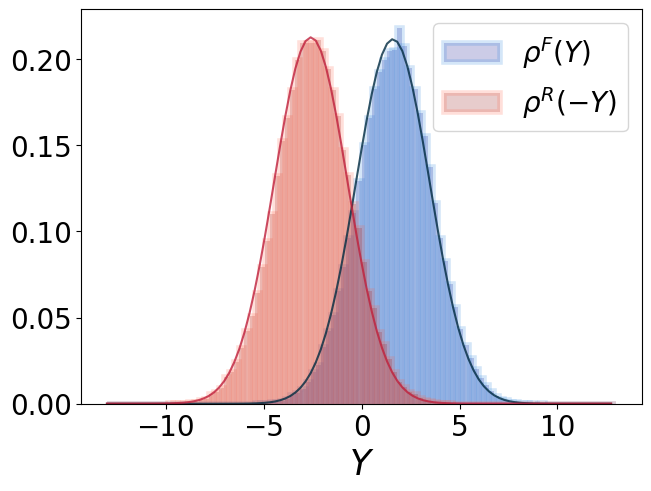

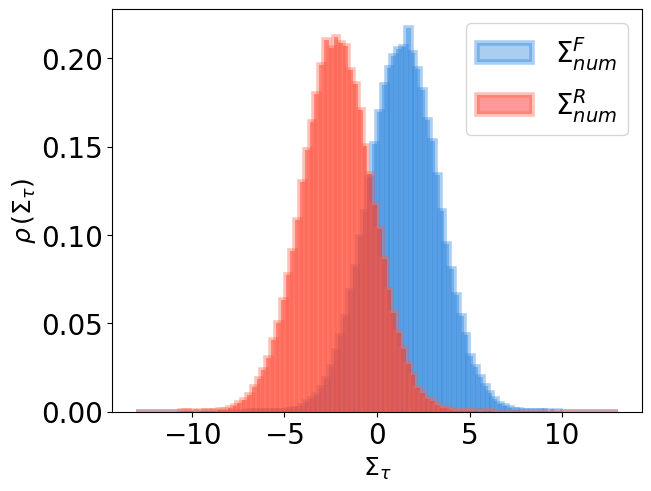

In [ ]:
plt.rcParams.update({'font.size': 20})
n_bins = 100 
range_hist = (-13,13)
#range_hist = (-5,5)

########## Work Histogram and Analitical curve ##########
plt.figure(constrained_layout=True)
nF, binsF, _ = plt.hist(nG_sF0 - nG_sF1 + nG_sF2_xdot, 
                               color = 'darkblue', range =  range_hist,
                               histtype='bar', linewidth=4, alpha= 0.2, ec=(0.165, 0.52, 0.87),
                               bins= n_bins, density=True,  label = r'$\rho^F(Y)$')

out_F   = leastsq(errfunc, init, args=(binsF[:-1], nF))
fit_F = fitfunc(out_F[0], binsF[:-1])
c_F = out_F[0]
print(c_F[0], c_F[1], c_F[2], c_F[3], c_F[4])

nR, binsR, _ = plt.hist(nG_sR0 - nG_sR1 + nG_sR2_xdot, 
                               color = "darkred", range =  range_hist, 
                               histtype='bar',  linewidth=4, alpha= 0.2, ec='tomato', 
                               bins= n_bins, density=True,  label = r'$\rho^R(-Y)$')

out_R   = leastsq(errfunc, init, args=(binsR[:-1], nR))
fit_R = fitfunc(out_R[0], binsR[:-1])

plt.plot(binsF[:-1], fit_F, color = (0/255, 42/255, 64/255), alpha= 0.8)
plt.plot(binsR[:-1], fit_R, color = (191/255, 31/255, 59/255), alpha= 0.8)

plt.xlabel(r'$Y$', fontsize = 25, labelpad = 4)
plt.legend(loc='upper right', fontsize = 20)
plt.savefig('/Users/fariaart/Downloads/dist_%s.pdf' %mu, transparent=False)

######### Gaussian
plt.figure(constrained_layout=True)
nGF, binsGF, _ = plt.hist(nG_sF0, 
                               color = (0.165, 0.52, 0.87), range = range_hist,
                               histtype='bar', linewidth=4, alpha= 0.4, ec=(0.165, 0.52, 0.87),
                               bins= n_bins, density=True,  label = r'$\Sigma^{F}_{num}$')

nGR, binsGR, _ = plt.hist(nG_sR0, 
                               color = "red", range =  range_hist, 
                               histtype='bar', linewidth=4, alpha= 0.4, ec='tomato', 
                               bins= n_bins, density=True,  label = r'$\Sigma^{R}_{num}$')

plt.xlabel(r'$\Sigma_{\tau}$', fontsize = 18, labelpad = 4)
plt.ylabel(r'$\rho\,(\Sigma_{\tau})$', fontsize = 18, labelpad = 2)
plt.legend(loc='upper right', fontsize = 20)


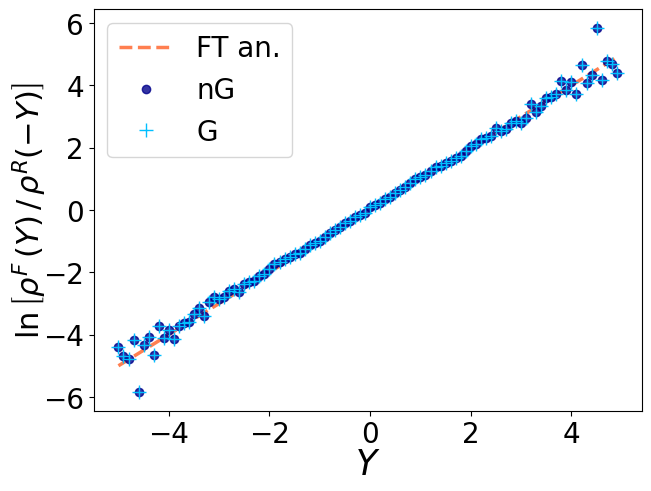

In [ ]:
plt.rcParams.update({'font.size': 20})
import warnings
warnings.filterwarnings('ignore')
########### W Division Histogram ###########

fig = plt.figure(constrained_layout=True)

#reversing the freq vector

n_Gd = nGF/nGF[::-1]
G_div = np.log(n_Gd)

n_d = nF/nF[::-1]
NG_div = np.log(n_d)

plt.plot(binsF[:-1], binsF[:-1], color = "coral",   linestyle = '--', linewidth = 2.5, label = 'FT an.', )
#plt.plot(x_an, y_target, color = "coral",   linestyle = '--', linewidth = 2.0)
plt.plot(binsF[:-1], NG_div, 'o', color = "darkblue", label = 'nG', markersize=6.0, alpha= 0.8)
plt.plot(binsGF[:-1], G_div, '+', color = "deepskyblue", label = 'G', markersize=10.0)

# Settings

plt.xlabel(r'$Y$', fontsize = 25, labelpad = -1)
plt.ylabel(r'$\ln\left[\rho^F\,(Y)\, /\, \rho^R(-Y)\right]$', fontsize = 22, labelpad = -4)
#plt.ylim(-7.5,7.5)

plt.legend(loc='upper left', fontsize = 20)
fig.savefig('/Users/fariaart/Downloads/FT_%s.pdf' %mu, transparent=False)